# Домашнее задание 3 - предобработка признаков, pandas, линейная регрессия

## Библиотеки для анализа данных

### NumPy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

**1. (0.2 балла)** Максимальный элемент в векторе среди элементов, перед которыми стоит нулевой.

In [3]:
def max_element(arr):
    # Находим индексы нулей, берём следующие за ними элементы
    mask = (arr[:-1] == 0)
    return arr[1:][mask].max()

# Проверка
x = np.array([6, 2, 0, 3, 0, 0, 5, 7, 0])
print(max_element(x))  # 5

5


**2. (0.2 балла)** Ближайший к числу элемент матрицы.

In [4]:
def nearest_value(X, v):
    idx = np.abs(X - v).argmin()
    return X.flat[idx]

# Проверка
X = np.arange(0, 10).reshape((2, 5))
print(nearest_value(X, 3.6))  # 4

4


**3. (0.2 балла)** Масштабирование столбцов матрицы.

In [5]:
def scale(X):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    return (X - means) / stds

# Проверка
X = np.array([[1, 4], [2, 0], [3, 2]], dtype=np.float64)
print(scale(X))

[[-1.22474487  1.22474487]
 [ 0.         -1.22474487]
 [ 1.22474487  0.        ]]


**4. (0.2 балла)** Статистики матрицы.

In [6]:
def get_stats(X):
    return {
        'det': np.linalg.det(X),
        'trace': np.trace(X),
        'min': X.min(),
        'max': X.max(),
        'frobenius_norm': np.linalg.norm(X, 'fro'),
        'eigenvalues': np.linalg.eigvals(X),
        'inverse': np.linalg.inv(X)
    }

X = np.array([[1, 2], [3, 4]], dtype=np.float64)
stats = get_stats(X)
for k, v in stats.items():
    print(f'{k}: {v}')

det: -2.0000000000000004
trace: 5.0
min: 1.0
max: 4.0
frobenius_norm: 5.477225575051661
eigenvalues: [-0.37228132  5.37228132]
inverse: [[-2.   1. ]
 [ 1.5 -0.5]]


**5. (0.2 балла)** Эксперимент: произведение случайных матриц и проверка ассоциативности следа.

In [7]:
all_close = True
for exp_num in range(100):
    A = np.random.randn(10, 10)
    B = np.random.randn(10, 10)
    # tr(AB) == tr(BA)
    if not np.allclose(np.trace(A @ B), np.trace(B @ A)):
        all_close = False
        break

print(f'tr(AB) == tr(BA) во всех экспериментах: {all_close}')

tr(AB) == tr(BA) во всех экспериментах: True


### Pandas

Ответим на вопросы о данных по авиарейсам в США.

In [8]:
df = pd.read_csv('2008.csv')
print(f'Размер: {df.shape}')
df.head()

Размер: (70000, 29)


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,6,18,3,2111.0,2055,2308.0,2300,WN,242,...,3.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,6,4,3,1426.0,1410,1730.0,1728,XE,2380,...,4.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,8,3,7,1143.0,1145,1501.0,1520,WN,1769,...,4.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,23,3,1141.0,1144,1323.0,1335,OO,3802,...,4.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,5,4,7,815.0,820,1243.0,1300,WN,399,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


**6. (0.3 балла)** Самая частая причина отмены рейса.

In [9]:
# A = Carrier, B = Weather, C = NAS, D = Security
print(df['CancellationCode'].value_counts())
print(f'\nСамая частая причина: {df["CancellationCode"].value_counts().idxmax()}')

CancellationCode
A    563
B    549
C    299
Name: count, dtype: int64

Самая частая причина: A


**7. (0.3 балла)** Среднее, минимальное и максимальное расстояние.

In [10]:
print(f'Среднее расстояние: {df["Distance"].mean():.2f}')
print(f'Минимальное расстояние: {df["Distance"].min()}')
print(f'Максимальное расстояние: {df["Distance"].max()}')

Среднее расстояние: 724.51
Минимальное расстояние: 31
Максимальное расстояние: 4962


**8. (0.3 балла)** Подозрительное минимальное расстояние.

In [11]:
min_dist = df['Distance'].min()
print(f'Минимальное расстояние: {min_dist}')
print(df[df['Distance'] == min_dist][['Month', 'DayofMonth', 'UniqueCarrier', 'FlightNum', 'Origin', 'Dest', 'Distance']])

# Расстояние без минимального выброса
print(f'\nСледующее минимальное: {df[df["Distance"] > min_dist]["Distance"].min()}')

Минимальное расстояние: 31
       Month  DayofMonth UniqueCarrier  FlightNum Origin Dest  Distance
1116      12          30            AS         65    WRG  PSG        31
6958      12          26            AS         65    WRG  PSG        31
17349      8          18            AS         64    PSG  WRG        31
27534      3          11            AS         64    PSG  WRG        31
46082      8           9            AS         65    WRG  PSG        31
48112      2          28            AS         64    PSG  WRG        31

Следующее минимальное: 36


**9. (0.3 балла)** Аэропорт с наибольшим числом вылетов.

In [12]:
top_origin = df['Origin'].value_counts().head(5)
print(top_origin)
print(f'\nБольше всего вылетов из: {top_origin.idxmax()}')

Origin
ATL    4134
ORD    3550
DFW    2793
DEN    2383
LAX    2082
Name: count, dtype: int64

Больше всего вылетов из: ATL


**10. (0.3 балла)** Среднее время полёта по аэропортам.

In [13]:
avg_airtime = df.groupby('Origin')['AirTime'].mean().sort_values(ascending=False)
print(f'Наибольшее среднее время полёта: {avg_airtime.idxmax()} ({avg_airtime.max():.2f} мин)')
print(f'\nТоп-5:')
print(avg_airtime.head())

Наибольшее среднее время полёта: SJU (205.20 мин)

Топ-5:
Origin
SJU    205.200000
BQN    193.954545
PSE    191.875000
STT    185.029412
ANC    165.415094
Name: AirTime, dtype: float64


**11. (0.5 балла)** Аэропорт с наибольшей долей задержанных рейсов (минимум 1000 вылетов).

In [14]:
origin_counts = df.groupby('Origin').size()
# Аэропорты с >= 1000 вылетов
big_airports = origin_counts[origin_counts >= 1000].index

df_big = df[df['Origin'].isin(big_airports)]
delay_ratio = df_big.groupby('Origin')['DepDelay'].apply(lambda x: (x > 0).mean())
print(f'Аэропорт с наибольшей долей задержек: {delay_ratio.idxmax()} ({delay_ratio.max():.4f})')
print(f'\nТоп-5 по доле задержек:')
print(delay_ratio.sort_values(ascending=False).head())

Аэропорт с наибольшей долей задержек: EWR (0.5112)

Топ-5 по доле задержек:
Origin
EWR    0.511159
IAH    0.468524
ORD    0.464507
DFW    0.459363
BWI    0.452519
Name: DepDelay, dtype: float64


---
## Линейная регрессия

Предсказание времени задержки отправления рейса (DepDelay).

### Подготовка данных

**12. (0.5 балла)** Считайте выборку и проанализируйте пропуски.

In [15]:
df = pd.read_csv('2008.csv')

print(f'Размер выборки: {df.shape}')
print(f'\nИмеются ли пропуски: {df.isnull().any().any()}')
print(f'Всего пропущенных элементов: {df.isnull().sum().sum()}')
print(f'Объектов с хотя бы одним пропуском: {df.isnull().any(axis=1).sum()}')
print(f'Признаков с хотя бы одним пропуском: {df.isnull().any(axis=0).sum()}')
print(f'\nПропуски по признакам:')
print(df.isnull().sum()[df.isnull().sum() > 0])

Размер выборки: (70000, 29)

Имеются ли пропуски: True
Всего пропущенных элементов: 355215
Объектов с хотя бы одним пропуском: 70000
Признаков с хотя бы одним пропуском: 16

Пропуски по признакам:
DepTime               1399
ArrTime               1556
TailNum                820
ActualElapsedTime     1582
CRSElapsedTime           9
AirTime               1582
ArrDelay              1582
DepDelay              1399
TaxiIn                1556
TaxiOut               1406
CancellationCode     68589
CarrierDelay         54747
WeatherDelay         54747
NASDelay             54747
SecurityDelay        54747
LateAircraftDelay    54747
dtype: int64


Анализ пропусков в целевой переменной и очистка данных.

In [16]:
print(f'Пропуски в DepDelay: {df["DepDelay"].isnull().sum()}')

# Анализируем объекты с пропущенной целевой переменной
missing_target = df[df['DepDelay'].isnull()]
print(f'\nОбъекты с пропущенным DepDelay:')
print(f'  Cancelled == 1: {(missing_target["Cancelled"] == 1).sum()} из {len(missing_target)}')
print('  -> Пропуски вызваны отменой рейсов')

# Исключаем: признак Cancelled (и CancellationCode, Diverted — связаны с отменой)
# Исключаем объекты с пропущенным DepDelay и с DepDelay == 0
df_clean = df[df['DepDelay'].notna() & (df['DepDelay'] != 0)].copy()

# Исключаем признаки связанные с отменой рейсов
df_clean = df_clean.drop(columns=['Cancelled', 'CancellationCode', 'Diverted'])

# Выделяем целевую переменную
y = df_clean['DepDelay'].values
X = df_clean.drop(columns=['DepDelay'])

print(f'\nРазмер после очистки: X={X.shape}, y={y.shape}')

Пропуски в DepDelay: 1399

Объекты с пропущенным DepDelay:
  Cancelled == 1: 1399 из 1399
  -> Пропуски вызваны отменой рейсов

Размер после очистки: X=(63404, 25), y=(63404,)


**13. (0.5 балла)** Преобразование времени из формата hhmm в часы и минуты.

In [17]:
time_features = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']

for feat in time_features:
    X[feat + '_Hour'] = (X[feat] // 100).where(X[feat].notna(), np.nan)
    X[feat + '_Minute'] = (X[feat] % 100).where(X[feat].notna(), np.nan)
    X = X.drop(columns=[feat])

print(f'Размер после преобразования времени: {X.shape}')
print([c for c in X.columns if 'Hour' in c or 'Minute' in c])

Размер после преобразования времени: (63404, 29)
['DepTime_Hour', 'DepTime_Minute', 'CRSDepTime_Hour', 'CRSDepTime_Minute', 'ArrTime_Hour', 'ArrTime_Minute', 'CRSArrTime_Hour', 'CRSArrTime_Minute']


**14. (0.5 балла)** Исключение признаков, сильно коррелирующих с целевой переменной, а также TailNum и Year.

In [18]:
# ArrDelay — задержка прибытия, напрямую зависит от задержки отправления
# CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay — 
#   это разбивка задержки на причины, то есть компоненты DepDelay
# TailNum — бортовой номер, не информативен для модели
# Year — один и тот же год (2008)

cols_to_drop = ['ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
                'SecurityDelay', 'LateAircraftDelay', 'TailNum', 'Year']

cols_to_drop = [c for c in cols_to_drop if c in X.columns]
X = X.drop(columns=cols_to_drop)

print(f'Размер после удаления: {X.shape}')
print(f'Оставшиеся признаки: {list(X.columns)}')

Размер после удаления: (63404, 21)
Оставшиеся признаки: ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut', 'DepTime_Hour', 'DepTime_Minute', 'CRSDepTime_Hour', 'CRSDepTime_Minute', 'ArrTime_Hour', 'ArrTime_Minute', 'CRSArrTime_Hour', 'CRSArrTime_Minute']


**15. (1 балл)** Масштабирование и one-hot-кодирование.

Посмотрим на гистограммы вещественных признаков:

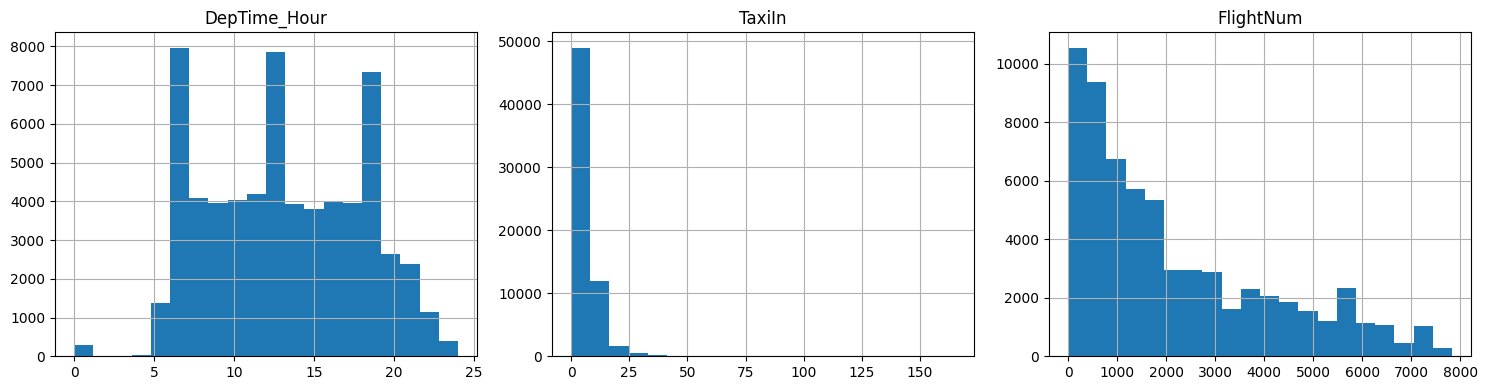

Проблема: признаки имеют разные масштабы. Масштабирование приведёт их к единому масштабу (среднее 0, дисперсия 1).


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
X['DepTime_Hour'].hist(bins=20, ax=axes[0])
axes[0].set_title('DepTime_Hour')
X['TaxiIn'].dropna().hist(bins=20, ax=axes[1])
axes[1].set_title('TaxiIn')
X['FlightNum'].hist(bins=20, ax=axes[2])
axes[2].set_title('FlightNum')
plt.tight_layout()
plt.show()

print('Проблема: признаки имеют разные масштабы. Масштабирование приведёт их к единому масштабу (среднее 0, дисперсия 1).')

In [20]:
def transform_data(data):
    """
    1. Заменяет пропуски: 0 для числовых, 'nan' для категориальных
    2. Масштабирует вещественные признаки (StandardScaler)
    3. One-hot-кодирует категориальные признаки
    """
    data = data.copy()
    
    # Разделяем на числовые и категориальные
    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    # Заполняем пропуски
    data[num_cols] = data[num_cols].fillna(0)
    data[cat_cols] = data[cat_cols].fillna('nan')
    
    # Масштабируем числовые
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
    
    # One-hot кодирование категориальных
    data = pd.get_dummies(data, columns=cat_cols)
    
    return data

In [21]:
X_transformed = transform_data(X)
print(f'Размер после преобразования: {X_transformed.shape}')
print(f'Количество признаков: {X_transformed.shape[1]}')

Размер после преобразования: (63404, 632)
Количество признаков: 632


**16. (0.5 балла)** Разбиение на обучение/контроль 70/30.

Для ускорения работы возьмём подвыборку.

In [22]:
# Берём подвыборку для ускорения (полные данные слишком большие)
np.random.seed(42)
n_sample = min(10000, len(X_transformed))
sample_idx = np.random.choice(len(X_transformed), n_sample, replace=False)

X_sampled = X_transformed.iloc[sample_idx].values
y_sampled = y[sample_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.3, random_state=42
)

print(f'Обучающая выборка: {X_train.shape}')
print(f'Тестовая выборка: {X_test.shape}')

Обучающая выборка: (7000, 632)
Тестовая выборка: (3000, 632)


### Scikit-learn

**17. (0.5 балла)** Линейная регрессия методом наименьших квадратов.

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print(f'LinearRegression:')
print(f'  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}')
print(f'  MAE:  {mean_absolute_error(y_test, y_pred_lr):.4f}')
print(f'  R²:   {r2_score(y_test, y_pred_lr):.4f}')
print(f'\nМакс. абс. значение коэффициента: {np.abs(lr.coef_).max():.4f}')
print(f'Среднее абс. значение коэффициентов: {np.abs(lr.coef_).mean():.4f}')
print('\nПроблема: без регуляризации коэффициенты могут быть очень большими,\nмодель переобучается и плохо обобщает.')

LinearRegression:
  RMSE: 33.5069
  MAE:  19.5311
  R²:   0.0553

Макс. абс. значение коэффициента: 217.8227
Среднее абс. значение коэффициентов: 9.6636

Проблема: без регуляризации коэффициенты могут быть очень большими,
модель переобучается и плохо обобщает.


**18. (1 балл)** Lasso и Ridge регрессия. График зависимости числа ненулевых коэффициентов от alpha.

In [24]:
# Обучение с параметрами по умолчанию
lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)

ridge = Ridge()
ridge.fit(X_train, y_train)

threshold = 1e-3
print(f'Lasso: коэффициентов близких к 0 (|w| < {threshold}): {(np.abs(lasso.coef_) < threshold).sum()} из {len(lasso.coef_)}')
print(f'Ridge: коэффициентов близких к 0 (|w| < {threshold}): {(np.abs(ridge.coef_) < threshold).sum()} из {len(ridge.coef_)}')

Lasso: коэффициентов близких к 0 (|w| < 0.001): 629 из 632
Ridge: коэффициентов близких к 0 (|w| < 0.001): 81 из 632


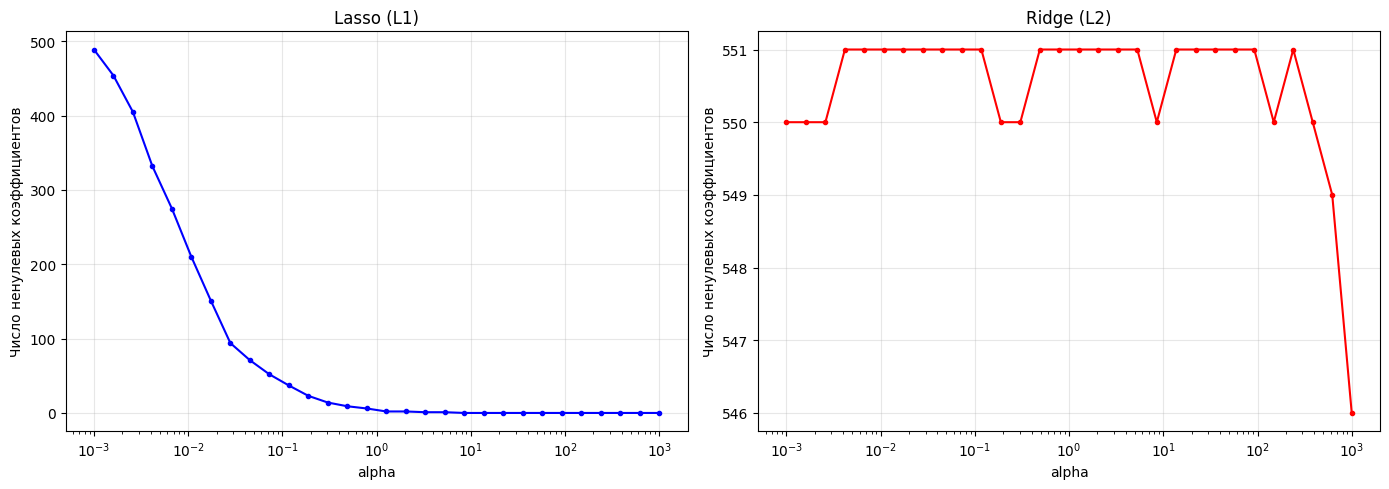

Lasso (L1) обнуляет коэффициенты при увеличении alpha — выполняет отбор признаков.
Ridge (L2) уменьшает коэффициенты, но не обнуляет их полностью.


In [25]:
# График зависимости числа ненулевых коэффициентов от alpha
alphas = np.logspace(-3, 3, 30)

lasso_nonzero = []
ridge_nonzero = []

for alpha in alphas:
    lasso_tmp = Lasso(alpha=alpha, max_iter=10000)
    lasso_tmp.fit(X_train, y_train)
    lasso_nonzero.append(np.sum(np.abs(lasso_tmp.coef_) > threshold))
    
    ridge_tmp = Ridge(alpha=alpha)
    ridge_tmp.fit(X_train, y_train)
    ridge_nonzero.append(np.sum(np.abs(ridge_tmp.coef_) > threshold))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(alphas, lasso_nonzero, 'b-o', markersize=3)
ax1.set_xscale('log')
ax1.set_xlabel('alpha')
ax1.set_ylabel('Число ненулевых коэффициентов')
ax1.set_title('Lasso (L1)')
ax1.grid(True, alpha=0.3)

ax2.plot(alphas, ridge_nonzero, 'r-o', markersize=3)
ax2.set_xscale('log')
ax2.set_xlabel('alpha')
ax2.set_ylabel('Число ненулевых коэффициентов')
ax2.set_title('Ridge (L2)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Lasso (L1) обнуляет коэффициенты при увеличении alpha — выполняет отбор признаков.')
print('Ridge (L2) уменьшает коэффициенты, но не обнуляет их полностью.')

Метрики для Ridge-регрессии:

In [26]:
y_pred_ridge = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae = mean_absolute_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)

print(f'Ridge (alpha=1.0, по умолчанию):')
print(f'  RMSE: {rmse:.4f}')
print(f'  MAE:  {mae:.4f}')
print(f'  R²:   {r2:.4f}')

Ridge (alpha=1.0, по умолчанию):
  RMSE: 33.1557
  MAE:  19.3064
  R²:   0.0750


Подбор коэффициента регуляризации для Ridge с помощью кросс-валидации:

In [27]:
# Для ускорения берём подвыборку из обучающих данных
n_cv = min(1000, len(X_train))
X_train_cv = X_train[:n_cv]
y_train_cv = y_train[:n_cv]

alphas_grid = np.logspace(-3, 3, 20)

# Скореры
scoring = {
    'neg_RMSE': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    Ridge(),
    param_grid={'alpha': alphas_grid},
    scoring=scoring,
    cv=kf,
    refit='R2',
    return_train_score=False
)

grid_search.fit(X_train_cv, y_train_cv)

print(f'Лучший alpha по R²: {grid_search.best_params_["alpha"]:.4f}')

Лучший alpha по R²: 1000.0000


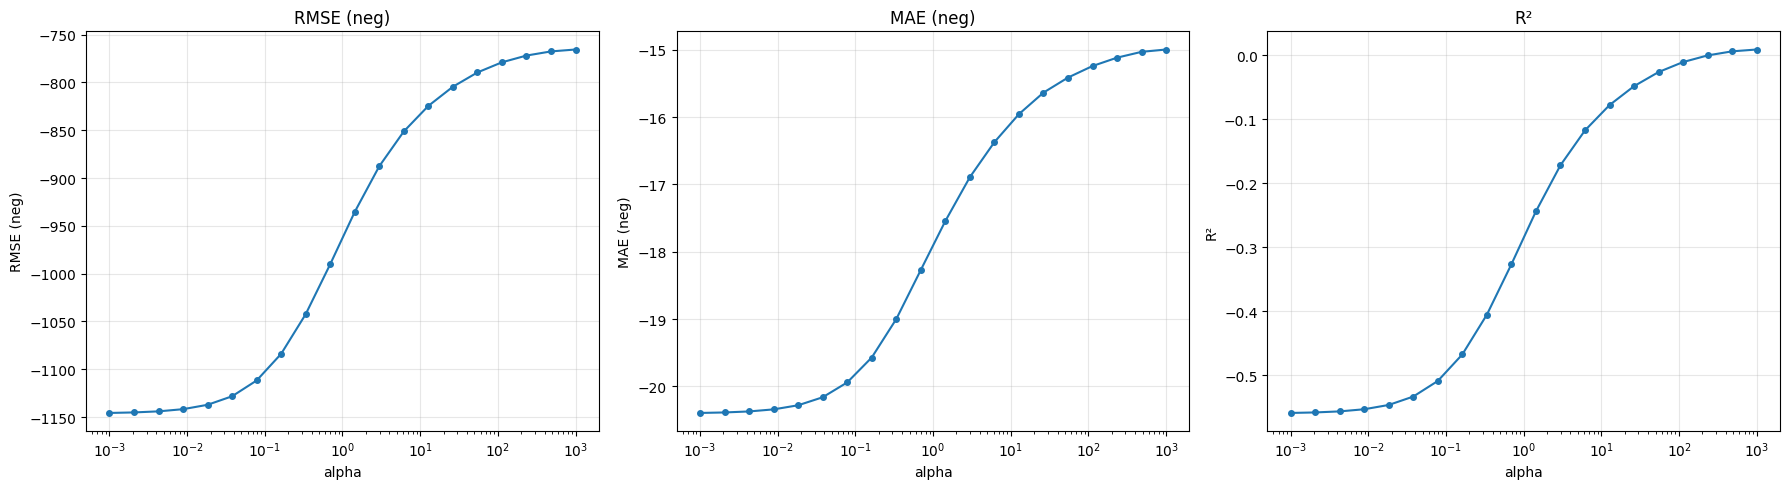

In [28]:
# Графики зависимости метрик от alpha
results = grid_search.cv_results_

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric, title in zip(axes,
    ['mean_test_neg_RMSE', 'mean_test_neg_MAE', 'mean_test_R2'],
    ['RMSE (neg)', 'MAE (neg)', 'R²']):
    ax.plot(alphas_grid, results[metric], '-o', markersize=4)
    ax.set_xscale('log')
    ax.set_xlabel('alpha')
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Обучаем Ridge с лучшим alpha на полной обучающей выборке
best_alpha = grid_search.best_params_['alpha']
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

y_pred_best = ridge_best.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'Ridge (alpha={best_alpha:.4f}, оптимальный):')
print(f'  RMSE: {rmse_best:.4f}')
print(f'  MAE:  {mae_best:.4f}')
print(f'  R²:   {r2_best:.4f}')
print(f'\nСравнение с alpha=1.0:')
print(f'  RMSE: {rmse:.4f} -> {rmse_best:.4f}')
print(f'  MAE:  {mae:.4f} -> {mae_best:.4f}')
print(f'  R²:   {r2:.4f} -> {r2_best:.4f}')

Ridge (alpha=1000.0000, оптимальный):
  RMSE: 33.1377
  MAE:  19.0539
  R²:   0.0760

Сравнение с alpha=1.0:
  RMSE: 33.1557 -> 33.1377
  MAE:  19.3064 -> 19.0539
  R²:   0.0750 -> 0.0760


**19. (0.5 балла)** Поиск объектов-выбросов с помощью Out-of-Fold предсказаний.

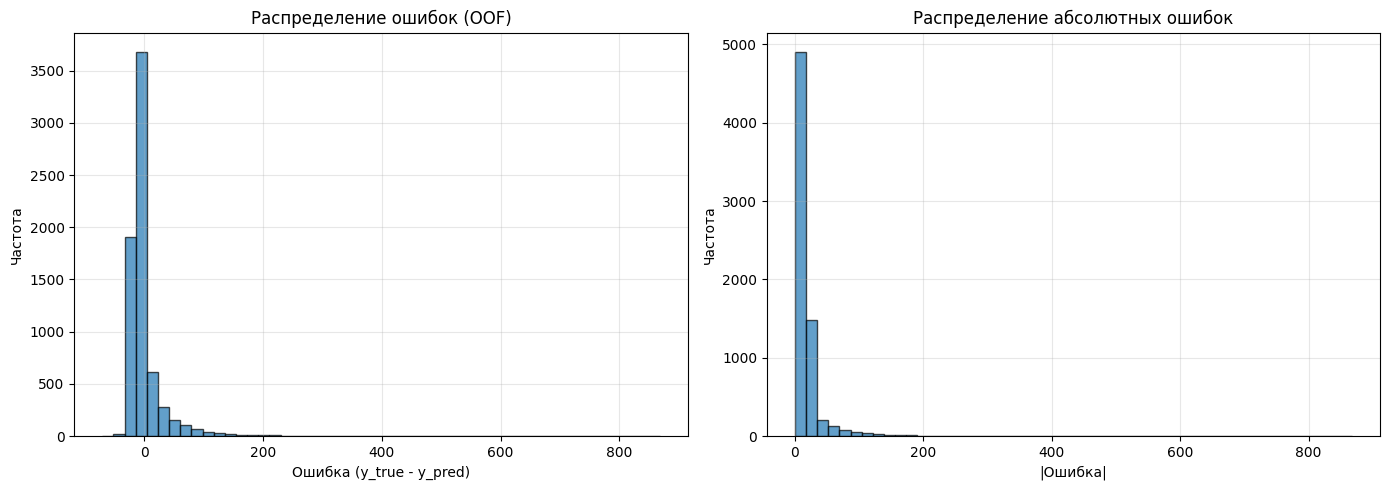

Порог для выбросов: |ошибка| > 109.78
Объектов-выбросов: 128 из 7000 (1.83%)

Распределение имеет тяжёлые хвосты — есть объекты с очень большими ошибками.
Именно эти выбросы сильно увеличивают MSE.


In [30]:
# Out-of-Fold предсказания
y_oof = cross_val_predict(Ridge(alpha=best_alpha), X_train, y_train, cv=5)

# Ошибки
errors = y_train - y_oof

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Ошибка (y_true - y_pred)')
ax1.set_ylabel('Частота')
ax1.set_title('Распределение ошибок (OOF)')
ax1.grid(True, alpha=0.3)

ax2.hist(np.abs(errors), bins=50, edgecolor='black', alpha=0.7)
ax2.set_xlabel('|Ошибка|')
ax2.set_ylabel('Частота')
ax2.set_title('Распределение абсолютных ошибок')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Порог для выбросов: ошибки > 3 стандартных отклонений
threshold_outlier = 3 * np.std(errors)
outlier_mask = np.abs(errors) > threshold_outlier
print(f'Порог для выбросов: |ошибка| > {threshold_outlier:.2f}')
print(f'Объектов-выбросов: {outlier_mask.sum()} из {len(errors)} ({outlier_mask.mean()*100:.2f}%)')
print(f'\nРаспределение имеет тяжёлые хвосты — есть объекты с очень большими ошибками.')
print('Именно эти выбросы сильно увеличивают MSE.')

## Выводы

1. Данные о рейсах содержат значительное количество пропусков, в основном связанных с отменёнными рейсами.

2. Предобработка данных (разделение времени на часы/минуты, удаление коррелированных признаков, масштабирование, one-hot кодирование) критически важна для линейных моделей.

3. Lasso-регрессия (L1) обнуляет коэффициенты при увеличении alpha, что делает отбор признаков. Ridge (L2) лишь уменьшает их.

4. Подбор alpha через кросс-валидацию позволяет выбрать оптимальный баланс между сложностью модели и качеством.

5. Распределение ошибок имеет тяжёлые хвосты — есть объекты-выбросы, которые непропорционально увеличивают MSE.